In [30]:
# !pip install SimpleITK
# !pip install python-bioformats==4.0.0
#!pip install matplotlib
# !pip install vtk
# !pip install connected-components-3d
# !pip install python-javabridge

In [17]:
import bioformats
import javabridge
import matplotlib.pyplot as plt

In [7]:
javabridge.start_vm(class_path=bioformats.JARS)

In [10]:
import bioformats
import javabridge
import numpy as np
import SimpleITK as sitk



file_path = 'D111_P15652.10a_day7_b.lsm.ics'

# Create an ImageReader
reader = bioformats.ImageReader(file_path)

# Get metadata
metadata = bioformats.get_omexml_metadata(file_path)
root = bioformats.OMEXML(metadata)
pixels = root.image().Pixels
num_channels = pixels.SizeC
num_slices = pixels.SizeZ

physical_size_x = pixels.PhysicalSizeX
physical_size_y = pixels.PhysicalSizeY
physical_size_z = pixels.PhysicalSizeZ

# Read the image using Bioformats for channel 0 only
image_stack = []
for z in range(num_slices):
    # Bioformats reads images in (T, Z, C, X, Y) order
    slice_data = reader.read(z=z, series=0, c=0, rescale=False)
    image_stack.append(slice_data)
    
# image_stack = np.array(image_stack)

image_stack=np.stack(image_stack, axis=0)
    
print(image_stack.shape,image_stack.min(),image_stack.max())

# Create a SimpleITK image from the pixel array
sitk_image = sitk.GetImageFromArray(image_stack)

if physical_size_x:
    sitk_image.SetSpacing((physical_size_x, physical_size_y, physical_size_z))
else: 
    sitk_image.SetSpacing((1, 1, 1))
sitk.WriteImage(sitk_image, "mcf10_b.nii.gz")


FileNotFoundError: [Errno 2] The file, "D111_P15652.10a_day7_b.lsm.ics", does not exist.: 'D111_P15652.10a_day7_b.lsm.ics'

In [15]:
import SimpleITK as sitk
import numpy as np

# Load the NIfTI image
sitk_image = sitk.ReadImage("ApoTome-04-09-2024-10_mask.nii.gz")

# Get the spacing (physical size) information
spacing = sitk_image.GetSpacing()
pixel_data = sitk.GetArrayFromImage(sitk_image)
print(pixel_data.shape)
print("Min:",np.min(pixel_data), "Max:", np.max(pixel_data) )

# Print the spacing
print("Spacing (physical size) in x, y, and z directions:", spacing)

(33, 1028, 1216)
Min: 0 Max: 1
Spacing (physical size) in x, y, and z directions: (0.17249999940395355, 0.17249999940395355, 1.0)


(342, 1028, 1216)
Min: 0.0 Max: 1.0


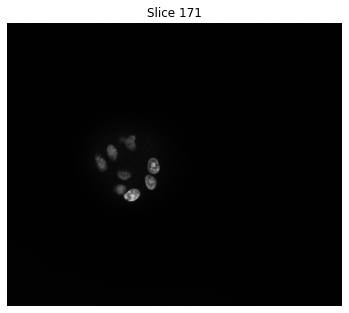

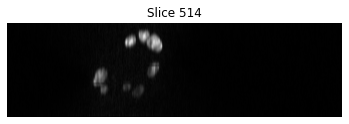

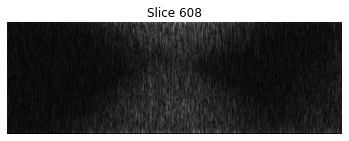

In [13]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Load the NIfTI image
sitk_image = sitk.ReadImage("scot_8_no.nii.gz")

# Get the original spacing and size
original_spacing = sitk_image.GetSpacing()
original_size = sitk_image.GetSize()

# Define the new isotropic spacing (minimum of original spacings)
new_spacing = (min(original_spacing), min(original_spacing), min(original_spacing))

# Compute the new size based on the new spacing, keeping the aspect ratio
new_size = [
    int(np.round(original_size[i] * (original_spacing[i] / new_spacing[i])))
    for i in range(3)
]

# Resample the image
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing(new_spacing)
resampler.SetSize(new_size)
resampler.SetOutputDirection(sitk_image.GetDirection())
resampler.SetOutputOrigin(sitk_image.GetOrigin())
resampler.SetInterpolator(sitk.sitkBSpline)  # Use BSpline interpolation for better quality

# Perform the resampling
resampled_image = resampler.Execute(sitk_image)

# Normalize the intensity values to [0, 1]
resampled_pixel_data = sitk.GetArrayFromImage(resampled_image)
resampled_pixel_data = (resampled_pixel_data - np.min(resampled_pixel_data)) / (np.max(resampled_pixel_data) - np.min(resampled_pixel_data))

# Convert the normalized array back to a SimpleITK image
normalized_image = sitk.GetImageFromArray(resampled_pixel_data)
normalized_image.SetSpacing(new_spacing)
normalized_image.SetDirection(resampled_image.GetDirection())
normalized_image.SetOrigin(resampled_image.GetOrigin())

# Save the normalized image
sitk.WriteImage(normalized_image, "normalized_resampled_image.nii.gz")

print(resampled_pixel_data.shape)
print("Min:", np.min(resampled_pixel_data), "Max:", np.max(resampled_pixel_data))

# Plot some slices to check the quality
def plot_slice(image_array, slice_index):
    plt.figure(figsize=(6, 6))
    plt.imshow(image_array[slice_index, :, :], cmap='gray')
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()

# Plot the middle slice in each dimension
plot_slice(resampled_pixel_data, resampled_pixel_data.shape[0] // 2)  # Middle slice in the z-direction
plot_slice(resampled_pixel_data.transpose(1, 0, 2), resampled_pixel_data.shape[1] // 2)  # Middle slice in the y-direction
plot_slice(resampled_pixel_data.transpose(2, 0, 1), resampled_pixel_data.shape[2] // 2)  # Middle slice in the x-direction


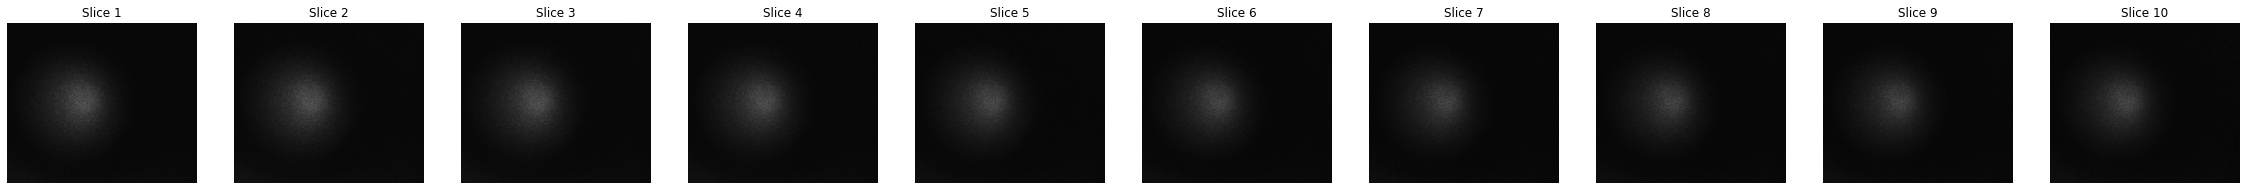

In [11]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

# Read the NIfTI image
rescaled_image = sitk.ReadImage("resampled_image.nii.gz")

# Get the array representation of the image
rescaled_array = sitk.GetArrayFromImage(rescaled_image)

# Plot the first 10 slices along the z-axis (assuming z-axis is the first axis)
num_slices = min(10, rescaled_array.shape[0])  # Ensure we don't exceed the number of slices

fig, axes = plt.subplots(1, num_slices, figsize=(40, 40))

# Loop through the first 10 slices and plot them
for i in range(num_slices):
    axes[i].imshow(rescaled_array[i, :, :], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Slice {i+1}")

plt.show()


In [1]:
import cc3d
import numpy as np
import vtk
from vtk.util import numpy_support
import SimpleITK as sitk

# Load your segmentation data
nrrd_path = "combined_e_day7_mask.nii.gz"
image = sitk.ReadImage(nrrd_path)
labels_in = sitk.GetArrayFromImage(image)

# Ensure that labels are consecutive integers starting from 1
labels_out = cc3d.connected_components(labels_in, connectivity=26)  # 6-connected

# Create a VTK image data object
vtk_image = vtk.vtkImageData()
vtk_image.SetDimensions(labels_out.shape[::-1])  # VTK uses a different order (z, y, x)
vtk_image.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)

# Copy NumPy array data to VTK image
vtk_array = numpy_support.numpy_to_vtk(labels_out.ravel(), deep=True)
vtk_image.GetPointData().SetScalars(vtk_array)

# Create a VTK Discrete Marching Cubes algorithm
discrete_marching_cubes = vtk.vtkDiscreteMarchingCubes()
discrete_marching_cubes.SetInputData(vtk_image)
discrete_marching_cubes.GenerateValues(np.max(labels_out), 1, np.max(labels_out))

# Apply smoothing
smooth_filter = vtk.vtkSmoothPolyDataFilter()
smooth_filter.SetInputConnection(discrete_marching_cubes.GetOutputPort())
smooth_filter.SetNumberOfIterations(700)  # Adjust the number of iterations as needed: sMOOTH

# Create a VTK renderer and render window
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.SetWindowName("Connected Components 3D Visualization")
render_window.SetSize(800, 800)
render_window.AddRenderer(renderer)

# Create a VTK render window interactor
render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetRenderWindow(render_window)

# Create a VTK lookup table
lut = vtk.vtkLookupTable()
lut.SetNumberOfTableValues(np.max(labels_out) + 1)
lut.Build()

# Assign different colors to each connected component label
for i in range(1, np.max(labels_out) + 1):
    color = np.random.rand(3)  # Random RGB color
    lut.SetTableValue(i, color[0], color[1], color[2])

# Create a VTK PolyDataMapper
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(smooth_filter.GetOutputPort())  # Use the smoothed output
mapper.SetLookupTable(lut)
mapper.SetScalarRange(0, np.max(labels_out))

# Create a VTK actor
actor = vtk.vtkActor()
actor.SetMapper(mapper)

# Add the actor to the renderer
renderer.AddActor(actor)

# Set up the renderer
renderer.SetBackground(0.8, 0.8, 0.8)  # Light gray background
renderer.ResetCamera()

# Add axes to the scene
axes_actor = vtk.vtkAxesActor()
axes_widget = vtk.vtkOrientationMarkerWidget()
axes_widget.SetOrientationMarker(axes_actor)
axes_widget.SetInteractor(render_window_interactor)
axes_widget.SetViewport(0.8, 0.0, 1.0, 0.2)  # Adjust the viewport position and size

# Start the rendering loop
render_window.Render()
render_window_interactor.Start()


In [1]:
import nibabel as nib
import numpy as np

# Load the 16-bit NIfTI image
input_file = 'scot_8_no.nii.gz'
img = nib.load(input_file)

# Get the image data as a numpy array
data = img.get_fdata()

# Convert the data to 32-bit (float32)
data_32bit = data.astype(np.float32)

# Create a new NIfTI image with the converted data
img_32bit = nib.Nifti1Image(data_32bit, img.affine, img.header)

# Save the new 32-bit NIfTI image
output_file = 'scot_8_32bit_image.nii.gz'
nib.save(img_32bit, output_file)

print(f"Converted image saved as {output_file}")


Converted image saved as scot_8_32bit_image.nii.gz


Converted image saved as scot_8_32bit_image.nii.gz


Final intensity range after normalization: min = 0.0, max = 1.0
Converted and normalized image saved as your_32bit_normalized_image.nii.gz
